In [1]:
import pprint as pp
import PySAM

# version must be at least 2.2.2
print(PySAM.__version__)

3.0.2


In [2]:
import PySAM.BatteryStateful as battery

params = {
          # specify power input
          "control_mode": 1, "input_power": 0, 
          # run second by second
          "dt_hr": 1/360,
          # lithium-ion type
          "chem": 1, 
          # setup size
          "nominal_energy": 10, "nominal_voltage": 500,
          # initial conditions
          "initial_SOC": 50.000, "maximum_SOC": 95.000, "minimum_SOC": 5.000, 
          # voltage parameters
          "voltage_choice": 0, "Vnom_default": 3.600, "resistance": 0.0001, "Vfull": 4.100, "Vexp": 4.050, "Vnom": 3.400, "Qfull": 2.250, "Qexp": 0.040, "Qnom": 2.000, "C_rate": 0.200, "Vcut": 2,
          # thermal parameters
          "mass": 507.000, "surface_area": 2.018, "Cp": 1004.000, "h": 20.000, "cap_vs_temp": [[-10, 60], [0, 80], [25, 1E+2], [40, 1E+2]], "T_room_init": 20,
          # cycling fade
          "life_model": 0, "cycling_matrix": [[20, 0, 1E+2], [20, 5E+3, 80], [20, 1E+4, 60], [80, 0, 1E+2], [80, 1E+3, 80],
                             [80, 2E+3, 60]], 
          # calendar fade
          "calendar_choice": 1, "calendar_q0": 1.020, "calendar_a": 0.003, "calendar_b": -7280.000, "calendar_c": 930.000, "calendar_matrix": [[-3.1E+231]],
          # no losses or replacements
          "loss_choice": 0, "replacement_option": 0}

b = battery.new()

for k, v in params.items():
    b.value(k, v)

b.setup()
b.execute()
pp.pprint(b.StatePack.export())

{'I': 0.0,
 'I_chargeable': -3012.9849130227035,
 'I_dischargeable': 3167.100000000183,
 'P': 0.0,
 'P_chargeable': -1730.5719248407627,
 'P_dischargeable': 1458.5234365267802,
 'Q': 10.125,
 'Q_max': 20.25,
 'SOC': 50.0,
 'T_batt': 20.0,
 'T_room': 20.0,
 'V': 552.4919894632768,
 'heat_dissipated': 0.0,
 'indices_replaced': (0.0,),
 'last_idx': 1.0,
 'loss_kw': 0.0,
 'n_replacements': 0.0}


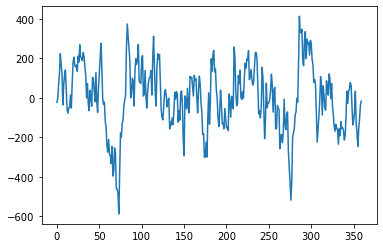

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# some frequency regulation signal for a single hour
seconds = np.arange(0, 360)
fr = np.sin(seconds / 20)
ft = np.fft.rfft(fr)
ind = np.argmax(ft)
for i in range(1, len(ft)):
    ft[i] *= np.random.normal() * np.max(ft) / 2
fr = np.fft.irfft(ft)
fr = fr / (np.max(fr) - np.min(fr)) * 1000
plt.plot(seconds, fr)

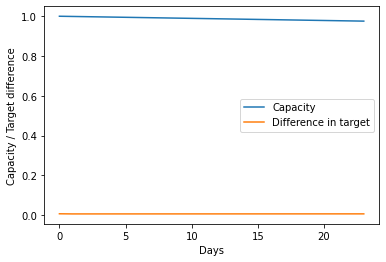

In [4]:
powers = fr

# on repeat for 24 hours
hrs = 24
Q_max0 = b.StatePack.Q_max
capacity = []
difference = []
for d in range(hrs):
    diff_day = 0
    for p in powers:
        b.Controls.input_power = p
        b.execute()
        diff_day += np.sqrt((p - b.StatePack.P) ** 2) / abs(p)
    capacity.append(b.StatePack.Q_max / Q_max0)
    difference.append(diff_day / hrs / len(powers))

plt.plot(range(hrs), capacity, label="Capacity")
plt.plot(range(hrs), difference, label="Difference in target")
plt.xlabel("Days")
plt.ylabel("Capacity / Target difference")
plt.legend()

In [5]:
# connect to cash flow model
...